# Compute total ellipticity by adding moments

In [1]:
%pylab inline
import sys 
sys.path.insert(0, '/global/common/cori/contrib/lsst/apps/anaconda/py2-envs/DESCQA/lib/python2.7/site-packages/')
import GCRCatalogs
gc_protoDC2 = GCRCatalogs.load_catalog('proto-dc2_v2.1.1')

Populating the interactive namespace from numpy and matplotlib


In [31]:
# Ellipticity functions from the WeakLensingDeblending code 
# https://github.com/LSSTDESC/WeakLensingDeblending/blob/master/descwl/model.py
# Credit David Kirkby
import math
import inspect

import numpy as np
import numpy.linalg

def sersic_second_moments(n,hlr,q,beta):
    """Calculate the second-moment tensor of a sheared Sersic radial profile.
    Args:
        n(int): Sersic index of radial profile. Only n = 1 and n = 4 are supported.
        hlr(float): Radius of 50% isophote before shearing, in arcseconds.
        q(float): Ratio b/a of Sersic isophotes after shearing.
        beta(float): Position angle of sheared isophotes in radians, measured anti-clockwise
            from the positive x-axis.
    Returns:
        numpy.ndarray: Array of shape (2,2) with values of the second-moments tensor
            matrix, in units of square arcseconds.
    Raises:
        RuntimeError: Invalid Sersic index n.
    """
    # Lookup the value of cn = 0.5*(r0/hlr)**2 Gamma(4*n)/Gamma(2*n)
    if n == 1:
        cn = 1.06502
    elif n == 4:
        cn = 10.8396
    else:
        raise RuntimeError('Invalid Sersic index n.')
    e_mag = (1.-q)/(1.+q)
    e_mag_sq = e_mag**2
    e1 = e_mag*np.cos(2*beta)
    e2 = e_mag*np.sin(2*beta)
    Q11 = 1 + e_mag_sq + 2*e1
    Q22 = 1 + e_mag_sq - 2*e1
    Q12 = 2*e2
    return np.array(((Q11,Q12),(Q12,Q22)))*cn*hlr**2/(1-e_mag_sq)**2

def moments_size_and_shape(Q):
    """Calculate size and shape parameters from a second-moment tensor.
    If the input is an array of second-moment tensors, the calculation is vectorized
    and returns a tuple of output arrays with the same leading dimensions (...).
    Args:
        Q(numpy.ndarray): Array of shape (...,2,2) containing second-moment tensors,
            which are assumed to be symmetric (only the [0,1] component is used).
    Returns:
        tuple: Tuple (sigma_m,sigma_p,a,b,beta,e1,e2) of :class:`numpy.ndarray` objects
            with shape (...). Refer to :ref:`analysis-results` for details on how
            each of these vectors is defined.
    """
    trQ = np.trace(Q,axis1=-2,axis2=-1)
    detQ = np.linalg.det(Q)
    sigma_m = np.power(detQ,0.25)
    sigma_p = np.sqrt(0.5*trQ)
    asymQx = Q[...,0,0] - Q[...,1,1]
    asymQy = 2*Q[...,0,1]
    asymQ = np.sqrt(asymQx**2 + asymQy**2)
    a = np.sqrt(0.5*(trQ + asymQ))
    b = np.sqrt(0.5*(trQ - asymQ))
    beta = 0.5*np.arctan2(asymQy,asymQx)
    e_denom = trQ + 2*np.sqrt(detQ)
    e1 = asymQx/e_denom
    e2 = asymQy/e_denom
    return sigma_m,sigma_p,a,b,beta,e1,e2

In [15]:
# Extract information about ellipticity
gc_protoDC2 = GCRCatalogs.load_catalog('proto-dc2_v2.1.1')
cat = gc_protoDC2.get_quantities(['morphology/diskHalfLightRadius',
                                  'morphology/diskMinorAxisArcsec',
                                  'morphology/diskScaleRadius',
                                  'morphology/diskAxisRatio',
                                  'morphology/diskHalfLightRadiusArcsec',
                                  'morphology/diskSersicIndex',
                                  'morphology/diskRadiusArcsec',
                                  'morphology/diskEllipticity',
                                  'morphology/spheroidHalfLightRadius',
                                  'morphology/spheroidMinorAxisArcsec',
                                  'morphology/spheroidScaleRadius',
                                  'morphology/spheroidAxisRatio',
                                  'morphology/spheroidHalfLightRadiusArcsec',
                                  'morphology/spheroidSersicIndex',
                                  'morphology/spheroidRadiusArcsec',
                                  'morphology/spheroidEllipticity',
                                  'morphology/positionAngle',
                                  'LSST_filters/spheroidLuminositiesStellar:LSST_r:rest',
                                  'LSST_filters/diskLuminositiesStellar:LSST_r:rest',
                                  'LSST_filters/totalLuminositiesStellar:LSST_r:rest',
                                  'ellipticity_1',
                                  'ellipticity_2'])

In [12]:
# Get disk and bulge fraction
disk_fraction = cat['LSST_filters/diskLuminositiesStellar:LSST_r:rest'] / cat['LSST_filters/totalLuminositiesStellar:LSST_r:rest']
bulge_fraction = cat['LSST_filters/spheroidLuminositiesStellar:LSST_r:rest'] / cat['LSST_filters/totalLuminositiesStellar:LSST_r:rest']

In [28]:
# Correct bug in position angle
PositionAngle_correct = cat['morphology/positionAngle']*(180/pi)**2 *pi/180.

In [37]:
# Compute second moments for each component
disk_second_moments = sersic_second_moments(n=1,
                                            hlr=cat['morphology/diskHalfLightRadiusArcsec'],
                                            q=cat['morphology/diskAxisRatio'],
                                            beta=PositionAngle_correct)

spheroid_second_moments = sersic_second_moments(n=4,
                                            hlr=cat['morphology/spheroidHalfLightRadiusArcsec'],
                                            q=cat['morphology/spheroidAxisRatio'],
                                            beta=PositionAngle_correct)

In [38]:
# Luminosity weighting of the moments for the 2 components
moments = disk_fraction * disk_second_moments + bulge_fraction * spheroid_second_moments

In [43]:
# Compute second moment statistics, including e1 e2
# Note that we need to roll the axis of the computed moments 
sigma_m,sigma_p,a,b,beta,e1,e2 = moments_size_and_shape(rollaxis(moments,2))

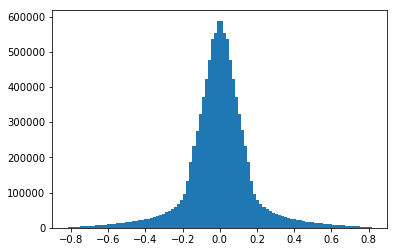

In [64]:
hist(e2,100);